In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
np.random.seed(1337)  # for reproducibility
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import get_file
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from keras.datasets import imdb
from keras.utils.np_utils import to_categorical
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
from sklearn.preprocessing import Normalizer
import h5py
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger


In [2]:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')


2154496/2144903 [==============================] - 1s 0us/step


In [3]:
# traindata, testdata = train_test_split(df, test_size=0.2, random_state=42)


# x_train = traindata.iloc[:,1:42]
# y_train = traindata.iloc[:,0]
# x_test = testdata.iloc[:,0]
# y_test = testdata.iloc[:,1:42]


df = pd.read_csv(path, header=None)

df.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]


print(df.shape)

df.drop_duplicates(keep='first', inplace = True)
df.dropna(inplace=True,axis=1) 




(494021, 42)


# New Section

In [4]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

encode_numeric_zscore(df, 'duration')
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')
encode_numeric_zscore(df, 'src_bytes')
encode_numeric_zscore(df, 'dst_bytes')
encode_text_dummy(df, 'land')
encode_numeric_zscore(df, 'wrong_fragment')
encode_numeric_zscore(df, 'urgent')
encode_numeric_zscore(df, 'hot')
encode_numeric_zscore(df, 'num_failed_logins')
encode_text_dummy(df, 'logged_in')
encode_numeric_zscore(df, 'num_compromised')
encode_numeric_zscore(df, 'root_shell')
encode_numeric_zscore(df, 'su_attempted')
encode_numeric_zscore(df, 'num_root')
encode_numeric_zscore(df, 'num_file_creations')
encode_numeric_zscore(df, 'num_shells')
encode_numeric_zscore(df, 'num_access_files')
encode_numeric_zscore(df, 'num_outbound_cmds')
encode_text_dummy(df, 'is_host_login')
encode_text_dummy(df, 'is_guest_login')
encode_numeric_zscore(df, 'count')
encode_numeric_zscore(df, 'srv_count')
encode_numeric_zscore(df, 'serror_rate')
encode_numeric_zscore(df, 'srv_serror_rate')
encode_numeric_zscore(df, 'rerror_rate')
encode_numeric_zscore(df, 'srv_rerror_rate')
encode_numeric_zscore(df, 'same_srv_rate')
encode_numeric_zscore(df, 'diff_srv_rate')
encode_numeric_zscore(df, 'srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_count')
encode_numeric_zscore(df, 'dst_host_srv_count')
encode_numeric_zscore(df, 'dst_host_same_srv_rate')
encode_numeric_zscore(df, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_serror_rate')
encode_numeric_zscore(df, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df, 'dst_host_rerror_rate')
encode_numeric_zscore(df, 'dst_host_srv_rerror_rate')


df.dropna(inplace=True,axis=1)
df[0:5]

# Convert to numpy - Classification
x_columns = df.columns.drop('outcome')
x = df[x_columns].values
dummies = pd.get_dummies(df['outcome']) # Classification
outcomes = dummies.columns
num_classes = len(outcomes)
y = dummies.values
df.groupby('outcome')['outcome'].count()

# Create a test/train split.  20% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
X_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

# scaler = Normalizer().fit(X)
# trainX = scaler.transform(X)
# # summarize transformed data
# np.set_printoptions(precision=3)
# #print(trainX[0:5,:])

# scaler = Normalizer().fit(T)
# testT = scaler.transform(T)
# # summarize transformed data
# np.set_printoptions(precision=3)
# #print(testT[0:5,:])

# y_train = np.array(Y)
# y_test = np.array(C)

# # reshape input to be [samples, time steps, features]
# X_train = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# X_test = np.reshape(testT, (testT.shape[0], 1, testT.shape[1]))


# print(X_train.shape)


# batch_size = 32


In [5]:
def create_model() :
  model = Sequential()
  model.add(LSTM(4,input_dim=x_train.shape[1]))
  model.add(Dropout(0.1))
  model.add(Dense(23)) 
  model.add(Activation('softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model


In [6]:
model = create_model()
model.summary()
print(X_train.shape)
print(y_train.shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 2000      
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 23)                115       
                                                                 
 activation (Activation)     (None, 23)                0         
                                                                 
Total params: 2,115
Trainable params: 2,115
Non-trainable params: 0
_________________________________________________________________
(116468, 1, 120)
(116468, 23)


In [7]:

cp = callbacks.ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/kddresults/", verbose=1, save_weights_only=True, monitor='val_acc',mode='max')
history = model.fit(X_train,y_train, validation_split=0.2, epochs=1000, batch_size=32, callbacks=[cp])


Epoch 1/1000
2900/2912 [============================>.] - ETA: 0s - loss: 0.5254 - accuracy: 0.9517
Epoch 1: saving model to /content/drive/My Drive/Colab Notebooks/kddresults/
2912/2912 [==============================] - 20s 5ms/step - loss: 0.5239 - accuracy: 0.9518 - val_loss: 0.1454 - val_accuracy: 0.9673
Epoch 2/1000
2897/2912 [============================>.] - ETA: 0s - loss: 0.1215 - accuracy: 0.9706
Epoch 2: saving model to /content/drive/My Drive/Colab Notebooks/kddresults/
2912/2912 [==============================] - 9s 3ms/step - loss: 0.1216 - accuracy: 0.9706 - val_loss: 0.0926 - val_accuracy: 0.9774
Epoch 3/1000
2899/2912 [============================>.] - ETA: 0s - loss: 0.0852 - accuracy: 0.9781
Epoch 3: saving model to /content/drive/My Drive/Colab Notebooks/kddresults/
2912/2912 [==============================] - 10s 3ms/step - loss: 0.0853 - accuracy: 0.9781 - val_loss: 0.0686 - val_accuracy: 0.9820
Epoch 4/1000
2911/2912 [============================>.] - ETA: 0s - 

{'loss': [0.5239092707633972, 0.12159373611211777, 0.08530734479427338, 0.07009534537792206, 0.06333418935537338, 0.05778135359287262, 0.05492306128144264, 0.05192115530371666, 0.049878381192684174, 0.04828089848160744, 0.04621971771121025, 0.04558241739869118, 0.04425672069191933, 0.04295390099287033, 0.0422574020922184, 0.04190665856003761, 0.04140456020832062, 0.0397830456495285, 0.039641283452510834, 0.03893448784947395, 0.03945581987500191, 0.03845225274562836, 0.03817586228251457, 0.037988774478435516, 0.0372164249420166, 0.03729907050728798, 0.03664882481098175, 0.03636295348405838, 0.035970836877822876, 0.034099843353033066, 0.0328017994761467, 0.03297370299696922, 0.03311099857091904, 0.03197874501347542, 0.031336043030023575, 0.030741212889552116, 0.030833063647150993, 0.029625141993165016, 0.02953415922820568, 0.03096061572432518, 0.029822679236531258, 0.0291774719953537, 0.029319142922759056, 0.02942797541618347, 0.028202900663018227, 0.027895420789718628, 0.026796124875545

[0.018146779388189316, 0.9976303577423096]

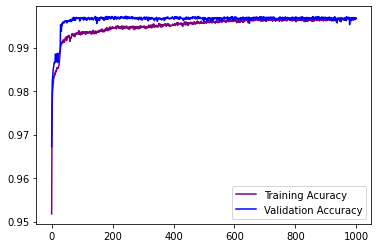

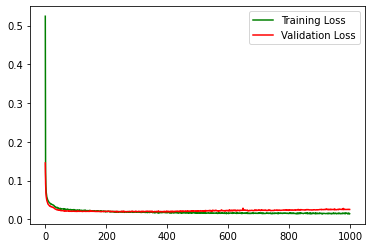

In [8]:
import matplotlib.pylab as plt

print(history.history)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure()
plt.plot(acc,color = 'purple',label = 'Training Acuracy')
plt.plot(val_acc,color = 'blue',label = 'Validation Accuracy')
plt.legend()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss,color = 'green',label = 'Training Loss')
plt.plot(val_loss,color = 'red',label = 'Validation Loss')
plt.legend()

model = create_model()
# Load the model weights that were saved at - "/content/drive/My Drive/Colab Notebooks/reuters/"
model.load_weights("/content/drive/My Drive/Colab Notebooks/kddresults/")
model.evaluate(X_test, y_test)


